## Round 2 - Regression


<img src="../../../coursedata/R2_Regression/SomePhoto.jpg" alt="Drawing" style="width: 300px"/>

In this round, we consider ML problems involving data points with real-valued labels $y$, which represent some quantity of interest. We often refer to such ML problems as **regression problems**. We will apply some basic ML methods to solve a simple regression problem. These methods aim at finding or learning a useful predictor function $h(\mathbf{x})$. Such a function allows to predict the label $y$ of a data point based on the features $\mathbf{x}$. A wide range of machine learning methods is obtained by combining different choices for the type of predictor functions (hypothesis space) and loss function (the quality measure used to rank predictors). These different combinations offer different tradeoffs between **computational complexity, robustness (against perturbation of data), and accuracy**.  

## Learning Goals

After completing this round, you should

- know how to formulate "real-world" applications as a regression problem by identifying data points, their features, and labels  
- know how to represent features and labels of data points using matrices and vectors (as numpy arrays)
- be able to apply ready-made regression methods to learn a useful predictor function from labeled data 
- evaluate the quality of linear regression methods using different loss function

## Background Material 

* [Video Lecture](https://www.youtube.com/watch?v=kHwlB_j7Hkc) on regression by [Prof. Andrew Ng](https://en.wikipedia.org/wiki/Andrew_Ng) 

* How to represent images via numpy arrays (matrices) explained here https://www.youtube.com/watch?v=xECXZ3tyONo

* Additional information on the Python libraries used in this exercise can be found here:

 - [NumPy](http://cs231n.github.io/python-numpy-tutorial/)
 - [matplotlib](https://matplotlib.org/tutorials/index.html#introductory) 
 - [Images and Numpy Arrays](https://matplotlib.org/tutorials/introductory/images.html)
 - [Pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html#min)
 - [Slicing numpy arrays](https://www.pythoninformer.com/python-libraries/numpy/index-and-slice/)

## The Problem 

Assume you have secured an internship at the city planning department of Helsinki. Your job is to analyze aerial photographs of the city area. Unfortunately, some of the aerial photographs have been damaged. The damaged images have a fraction of their pixels replaced by completely black pixels. To improve the image quality you can use machine learning! 

Let us model the problem of recovering the original image as a machine learning problem. The data points in this problem are individual pixels of an image. Each data point (pixel) is characterized by certain features. The quantity of interest (the label) of a pixel is the correct grayscale value. For uncorrupted pixels we know the label which is given by the grayscale value ($0...255$) of that pixel. 

For the corrupted pixels we do not know the true label (grayscale value). Therefore, we have to learn a predictor which reads in the features of a corrupted pixel and predicts (guesses) the label (grayscale) value of that pixel. To learn a reasonable predictor, we can try to compare its predictions for the uncorrupted pixels for which we know the correct label (grayscale value). 

<a id='handsondata'></a>
<div class=" alert alert-info">
    
### Demo. Loading the Corrupted Image
    
The code snippet below reads in the corrupted aerial photograph and stores the grayscale values of the pixels in the numpy array `Photo`. The corrupted pixels are completely black (grayscale value is zero). We consider the pixel with coordinates (m,n) as corrupted if the grayscale value `Photo[m,n]` is smaller than 1.

</div>

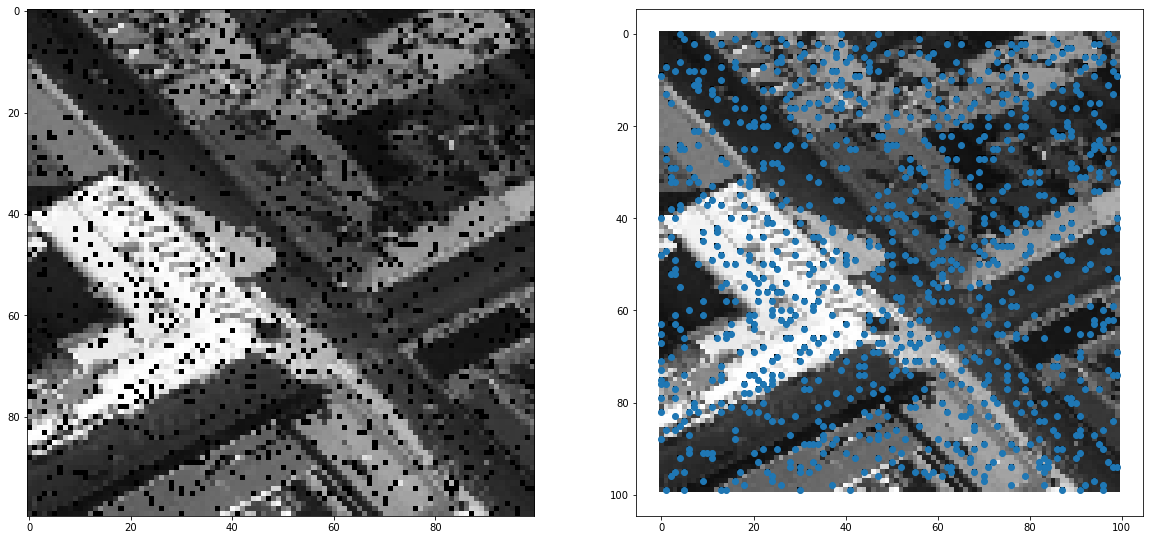

In [1]:
# the library "cv2" provides methods for loading image files into numpy arrays 
import cv2
# the library "pyplot" provides functions for plotting data 
import matplotlib.pyplot as plt      
# the library "numpy" provides functions for matrices and vectors 
import numpy as np 
# the library "sklearn.linear_model" provides functions for fitting linear predictors to data points 
from sklearn.linear_model import LinearRegression
# the library "sklearn.metrics" provides functions for evaluating different loss functions 
from sklearn.metrics import mean_squared_error

# filename of image file containing corrupted pixels 
corrupted = '/coursedata/R2_Regression/SomePhotoCorrupted.bmp'

# read in the corrupted aerial photograph as grayscale (second argument 0) and store it in variable `Photo`
Photo = cv2.imread(corrupted, 0)
# make sure that photograph is represented by 100 by 100 pixels 
Photo = cv2.resize(Photo, (100, 100))
# create a figure with two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 10)) # read more about how subplots work at: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html
# plot photograph (first subplot)
ax[0].imshow(Photo, cmap='gray')

# find indices of numpy array corresponding to corrupted (black) pixels
error_idx = np.where(Photo<1)  # determine corrupted pixels (those whose grayscale = 0)
# vertical position ("row index") of corrupted pixels 
rows_err = error_idx[0]
# horizontal position ("column index") of corrupted pixels 
cols_err = error_idx[1]
# plot photograph (second subplot)
ax[1].imshow(Photo, cmap='gray')
# mark corrupted pixels with a blue dot 
ax[1].scatter(cols_err, rows_err)
# display the image 
plt.show()

## The Data

Our goal is to learn an accurate predictor $h(\mathbf{x})$ for the grayscale $y$ of a particular pixel in an aerial photograph. The prediction $h(\mathbf{x})$ is based on several features (characteristics) $\mathbf{x} = \big(x_{1},\ldots,x_{n}\big)^{T}$ of the pixel. Some of these features are obtained from the grayscale values of nearby pixels. We expect that the grayscale values of nearby pixels are typically similar. 

To learn a predictor $h(\mathbf{x})$, we use uncorrupted pixels (those which are not black) in the aerial photograph. Let us enumerate these uncorrupted pixels by $i=1,\ldots,m$. The $i$th uncorrupted pixels is characterized by the features $\mathbf{x}^{(i)} \in \mathbb{R}^{n}$ and the grayscale value $y^{(i)}$ of the pixel itself. We then use ML methods to find (or learn) a useful predictor $h(\mathbf{x})$ which yields a small average prediction error $h(\mathbf{x}^{(i)}) - y^{(i)}$ for $i=1,\ldots,m$.

<a id='handsondata'></a>
<div class=" alert alert-info">
    
### Demo. Get the features
    
The following code snippet defines a function `X,y= GetFeaturesLabels(m,n)` which reads in data of the pixels and their greyscales. The input parameters are the number `m` of data points and the number `n` of features to be used for each data point. The function returns a feature matrix $\mathbf{X}$ and label vector $\mathbf{y}$. 

The features $\mathbf{x}^{(i)}$ describing pixels are stored in the rows of the numpy array `X` (of shape (m,n)) and the corresponding greyscale values $y^{(i)}$ in the numpy array `y` (shape (m,1)). The two numpy arrays represent the feature matrix $\mathbf{X} = \begin{pmatrix} \mathbf{x}^{(1)} & \ldots & \mathbf{x}^{(m)} \end{pmatrix}^{T}$ and the label vector $\mathbf{y} = \big( y^{(1)}, \ldots, y^{(m)} \big)^{T}$. 
 
A key challenge in ML is to find out the most relevant features of data points that will adequately describe its properties. This challenge is the subject of the ML subfield [Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering).

In this round, we will use features obtained form the neighborhood of some pixel $i$. The first feature (denoted `x1` in the code) is the average (mean) grayscale value the pixel neighborhood (collection of pixels which surround the pixel in question). In partiuclar, we will use $3 \times 3$ pixel neighborhood to calculate the mean grayscale value. The second feature (denoted `x2` in the code) is the [median](https://en.wikipedia.org/wiki/Median) grayscale value of $3 \times 3$ pixel neighborhood. 

In principle we can use any quantity as a feature. In particular, we can use additional features which are obtained by a random nubmer generator. Later, we will check if these random features (which obviously do not contain any relevant information about the label which we want to predict) are useful for building linear predictor (see "Student Task Varying Number of Features"). 
    
</div>

<img src="../../../coursedata/R2_Regression/GetFeatures.jpg" alt="Drawing" style="width: 900px"/>

In [2]:
# Pandas provides functions for loading (storing) data from (to) files
import pandas as pd  
# the library "cv2" provides powerful methods for image processing and computer vision
import cv2 
# import functions for displaying and plotting data 
from matplotlib import pyplot as plt 
from IPython.display import display, HTML
# library "numpy" provides matrix (represented by numpy arrays) operations 
import numpy as np   
# library "random" provides functions for generating random numbers
import random

def GetFeaturesLabels(m, n):
    
    # m - number of data points (pixels)
    # n - number of features
    
    # filename of image file containing corrupted pixels
    corrupted = '/coursedata/R2_Regression/SomePhotoCorrupted.bmp'
    
    # read corrupted image as numpy array
    Photo = cv2.imread(corrupted, 0)
    # set image size (100 by 100 pixels)
    Photo = cv2.resize(Photo, (100, 100))
    
    # get image height and width 
    imgheight = Photo.shape[0]
    imgwidth = Photo.shape[1]

    # determine "uncorroputed pixels" by finding indices of those pixels with grayscale value larger than 0
    good_idx = np.where(Photo > 0)

    # store the vertical coordinate (row index) of uncorroputed pixels in numpy array `rows`
    rows = good_idx[0] 
    # store the horizontal coordinate (column index) of uncorroputed pixels in numpy array `cols` 
    cols = good_idx[1]
    
    # set pads for defining pixel neighborhood and augmenting the image
    wp = 1
    hp = 1

    # augment image with stripes such that we can also define neighborhoods of border pixels 
    # the values of these pixels are zero
    tmp = np.vstack((np.zeros((wp, imgwidth)), Photo, np.zeros((wp, imgwidth))))
    augmented = np.hstack((np.zeros((2*wp + imgheight, hp)), tmp, np.zeros((2*wp + imgheight, hp))))

    # initialize feature vectors `x1`, `x2`and label vector `y` as numpy arrays 
    x1 = np.zeros((m,1))
    x2 = np.zeros((m,1))
    y = np.zeros((m,1))
    
    # calculate the mean and median gray scale value of a pixel neighborhood 
    # here we define 3x3 pixel matrix surrounding a pixel as its neighborhood 
    for iter_datapoint in range(m):
        row = rows[iter_datapoint] + wp # add wp to get the index of same data point in augmented Photo
        col = cols[iter_datapoint] + hp # add hp to get the index of same data point in augmented Photo

        # get the true label (gray scale value) of a datapoint (pixel)
        y[iter_datapoint] = augmented[row, col]

        # get values of pixel with its neighborhood (3x3 matrix) from image
        neighbors = np.copy(augmented[(row-wp):(row+wp+1), (col-hp):(col+hp+1)])
        # set value of a data point to 0 in order to exlude this value from calculation
        # for the 3x3 array the indices for this data point(center of the neighborhood) is [1,1]
        neighbors[1,1] = 0
        
        # calculate the feature of a data point (pixel) - the mean and median gray level of the neighborhoud
        # zero values are exluded from calculation
        x1[iter_datapoint] = np.mean(neighbors[neighbors != 0])   
        x2[iter_datapoint] = np.median(neighbors[neighbors != 0]) 
        
    np.random.seed(30) # this is done so that every time that below np.random.randn is called, it produces the same output. 
                       # this is needed for testing purposes
    # lets add some "extra features" here 
    X = np.hstack((x1, x2, np.random.randn(n,m).T)) 
    
    X = X[:,:n]
    return X, y

## Visualize Data

Scatter plots visualize data points by representing them as "dots" in the two-dimensional plane. Scatter plots can help to develop an intuition for the relation between features and labels of data points. 


<a id='drawplot'></a>
<div class=" alert alert-info">
    
### Demo. Scatterplots of Features and Labels

<p>The code snippet below creates scatterplots showing the first two features $x^{(i)}_{1}$, $x^{(i)}_{2}$ and the label $y^{(i)}$ (greyscale) for each data point. It also creates a third scatterplot with the third feature $x^{(i)}_{3}$ and the label $y^{(i)}$ (greyscale) for each data point.</p>
</div>

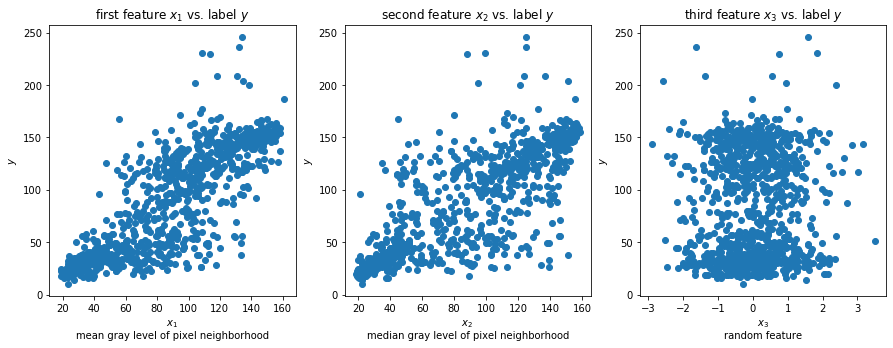

In [3]:
# pyplot library provides functions for plotting data 
from matplotlib import pyplot as plt 

# read in features and labels of m=1000 data points, each of which 
# is characterized by n=10 features 
X,y = GetFeaturesLabels(1000, 10)

# create a figure with 3 subplots arranged in 1 row 
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# create first subplot 
axs[0].scatter(X[:,0], y)
axs[0].set_title('first feature $x_{1}$ vs. label $y$')
axs[0].set_xlabel('$x_{1}$ \nmean gray level of pixel neighborhood')
axs[0].set_ylabel('$y$')

# create second subplot 
axs[1].scatter(X[:,1], y)
axs[1].set_xlabel('$x_{2}$ \nmedian gray level of pixel neighborhood')
axs[1].set_title('second feature $x_{2}$ vs. label $y$')
axs[1].set_ylabel('$y$')

# create second subplot 
axs[2].scatter(X[:,2], y)
axs[2].set_xlabel('$x_{3}$ \nrandom feature')
axs[2].set_title('third feature $x_{3}$ vs. label $y$')
axs[2].set_ylabel('$y$')

# display the figure containing two subplots 
plt.show()

Take a look at the scatter plots and note the relationship between each feature and label. 
How do the scatter plots of the features $x_{1}$ and $x_{2}$ (mean and median gray level of the pixel neighborhood) differ from the scatter plot using the random feature $x_{3}$?

<a id='drawplot'></a>
<div class=" alert alert-warning"><b>Student Task.</b> Scatter Plots.

<p>Create a scatterplot with x-axis (horizontal axis) representing the fourth feature $x^{(i)}_{4}$ and $y$-axis (vertical axis) representing the label values $y^{(i)}$ for each of the $m=10$ labeled data points $\big(\mathbf{x}^{(i)},y^{(i)}\big)$. 
</p>
<p><b>Hint:</b>  Remember, indexing in python starts from 0, not 1.</p>
</div>

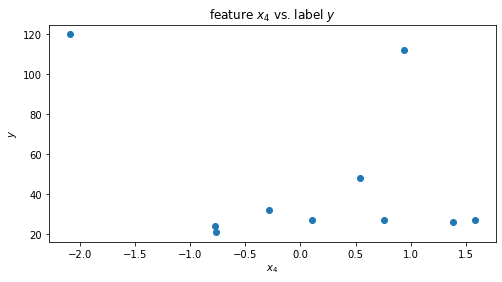

In [4]:
from matplotlib import pyplot as plt 

def studentScatterPlot(X, y):
    fig, axes = plt.subplots(1, 1, figsize=(8, 4))
    ### STUDENT TASK ###
    # get the correct feature from X and save to X_4
    # X_4 = ...
    # use X_4 to create the scatter plot
    # axes.scatter ... 
    X_4 = X[:,3]
    axes.scatter(X_4, y)
    #raise NotImplementedError()
    axes.set_title('feature $x_{4}$ vs. label $y$')
    axes.set_xlabel(r'$x_{4}$')
    axes.set_ylabel('$y$')
    return X_4, axes

X,y = GetFeaturesLabels(10,10)   # read in features and labels

axes = studentScatterPlot(X, y)
plt.show()

sanity check tests passed!


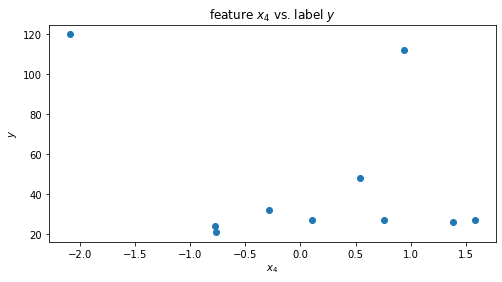

In [5]:
# this cell constains visible tests (sanity checks) and 
# hidden tests which are used for grading student solutions 

X, y = GetFeaturesLabels(10,10)   # read in features and labels
X_4, axes = studentScatterPlot(X, y)
assert X_4.shape == (10,), "'X_4' has wrong dimensions."
assert X_4[1] > X_4[2], "'X_4' values are not correct"
assert X_4[9] > X_4[8], "'X_4' values are not correct"


print('sanity check tests passed!')

## Linear Regression 

We try to predict the label $y$ of a data point (representing a pixel in an aerial photograph) 
based on $n$ properties or features $\mathbf{x}=(x_{1},\ldots,x_{n})^{T} \in \mathbb{R}^{n}$ of that data point. To this end, we try to find (or learn) a predictor function $h(\mathbf{x})$ such that $y \approx h(\mathbf{x})$. 

Linear regression uses linear predictor functions of the form 

\begin{equation*}
h^{(\mathbf{w})}(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x} \mbox{ for some weight vector } \mathbf{w} \in \mathbb{R}^{n}.
\label{eq1}
\tag{1}
\end{equation*}
\
\
Note that for vectors $\mathbf{w}=\big(w_{1},\ldots,w_{n}\big)^{T} \in \mathbb{R}^{n}$ and $\mathbf{x}=\big(x_{1},\ldots,x_{n}\big)^{T}\in \mathbb{R}^{n}$,
\begin{equation*}
\mathbf{w}^{T} \mathbf{x} =  w_{1} x_{1}+...+w_{n} x_{n} = \sum_{r=1}^{n} w_{r} x_{r}.
\end{equation*} 

<a id='drawplot'></a>
<div class=" alert alert-info">
    
### Demo. Build a Linear Predictor

The code snippet below shows how to use the `LinearRegression` class from the Python library `scikit-learn` to learn an optimal predictor from the set of linear predictors $h(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$ and find its  optimal weight vector $\mathbf{w}_{\rm opt}$ .

The linear regression model is fitted to the input data $\mathbf{X}$ by calling the function `LinearRegression.fit()`. The function finds the optimal weight vector $\mathbf{w}_{\rm opt}$ and stores it in the attribute `LinearRegression.coef_` of the `LinearRegression` object.

You can find the documentation of the `LinearRegression` class under [this link](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn-linear-model-linearregression). 

</div>

In [6]:
# the class "LinearRegression" from the library scikit-learn allows to find 
# linear predictors 
from sklearn.linear_model import LinearRegression
# import some convenient tools for plotting data 
from IPython.display import display, Math

# read in features and labels (grayscale values) of uncorrupted pixels 
X,y = GetFeaturesLabels(1000, 2)   

# create a LinearRegression object with no intercept term
# this object represents the space of predictor functions h(x) = w^{T}x
reg = LinearRegression(fit_intercept=False) 

# find optimal weight vector   
reg = reg.fit(X, y)

# we can read out the optimal weight vector using reg.coef_ 
optimal_weight = reg.coef_

# reshape the numpy array to have dimension (n,1) 
optimal_weight = optimal_weight.reshape(-1,1)

# plot the optimal weight vector entries 
display(Math(r'$\mathbf{w}_{\rm opt} ='))
print(optimal_weight)

<IPython.core.display.Math object>

[[0.66131446]
 [0.34372099]]


Now that we have trained our linear predictor, let's use it to predict the grayscale value of the corrupted pixels in our image.

<a id='handsondata'></a>
<div class=" alert alert-info">
    
### Demo. Display Recovered Pixels
<p>    
The code snippet below reads in a weight vector $\mathbf{w} \in \mathbb{R}^{n}$ that defines a linear predictor $h(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$ for the grayscale value $y$ of a pixel. The prediction is based on the features $\mathbf{x} = \big(x_{1},\ldots,x_{n}\big)^{T}$ that characterize a pixel. 

These features are obtained by the neighbouring pixels of a given "target" pixel (which might be corrupted). In order to define the neighbourhood also for border pixels, we need to agument the image by stripes of all-zero pixels [in the same way as in function `GetFeaturesLabels()`]. 

The grayscale value of each corrupted pixel (which has grayscale value 0) is replaced by the prediction $\hat{y} = h(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$. The resulting (recovered) image, with black pixels replaced by grayscale $\hat{y}$, is then depicted. 
</p>
</div>

In [7]:
def DisplayRecoveredPixels(w):
    
    # w - optimal weights
    # w is 1-D np.array or scalar 

    # filename of image file containing corrupted pixels
    corrupted = '/coursedata/R2_Regression/SomePhotoCorrupted.bmp'

    # read in the corrupted aerial photograph as grayscale (second argument 0) 
    # and store it in variable img
    Photo = cv2.imread(corrupted, 0)
    
    # make sure that photograph is represented by 100 by 100 pixels 
    Photo = cv2.resize(Photo, (100, 100))
    
    imgwidth = Photo.shape[0]
    imgheight = Photo.shape[1]
    
    # determine corrupted pixels (those whose grayscale = 0)
    error_idx = np.where(Photo < 1)
    
    # store the vertical coordinate (row index) of corrupted pixels in numpy array rows_err 
    rows_err = error_idx[0]
    # store the horizontal coordinate (column index) of corrupted pixels in numpy array cols_err 
    cols_err = error_idx[1]
    # determine number of corrupted pixels 
    errsize = rows_err.shape[0]
    
    # create a numpy array x1 and x2 which we use to store the features vectors of corrupted pixels
    x1 = np.zeros((errsize,1)) 
    x2 = np.zeros((errsize,1))
    
    # set pads for defining pixel neighborhood and augmenting the image
    wp = 1
    hp = 1   

    # augment image with stripes such that we can also define neighborhoods of border pixels 
    tmp = np.vstack((np.zeros((wp, imgwidth)), Photo, np.zeros((wp, imgwidth))))
    augmented = np.hstack((np.zeros((2*wp + imgheight, hp)), tmp, np.zeros((2*wp + imgheight, hp))))
   
    # calculate the mean and median gray scale value of a pixel neighborhood 
    # here we define 3x3 pixel matrix surrounding a pixel as its neighborhood
    for iter_datapoint in range(errsize): 
        # determine row index in augmented image (add offset wp)
        row = rows_err[iter_datapoint]+wp
        # determine column index in augmented image (add offset hp)
        col = cols_err[iter_datapoint]+hp
        
        # calculate the feature of a data point (pixel) - the mean gray level of the neighborhoud 
        neighbors = augmented[(row-wp):(row+wp+1), (col-hp):(col+hp+1)]

        # zero values are exluded from mean calculation
        x1[iter_datapoint] = np.mean(neighbors[neighbors != 0])
        x2[iter_datapoint] = np.median(neighbors[neighbors != 0])
        
    np.random.seed(30) # this is done so that every time that below np.random.randn is called, 
                       # it produces the same output. 
                       # this is needed for testing purposes
    
    # define number (n) and length(m) of "extra (random) features" 
    m = errsize # length of feature vector    
    # number of features (equal to length of weight vector)
    n = w.shape[0]
    
    # lets add some "extra (random) features" here
    X = np.hstack((x1,x2,np.random.randn(m,n))) 
    X = X[:,:n]
    
    # compute predicted label values (grayscale level) of corrupted pixels 
    y_hat = X.dot(w)

    # the range of gray scale value (0-255) might change after multiplication with weight w
    # therefore we need to remove all values smaller than 0 and bigger than 255
    y_hat = np.clip(y_hat,0,255)
    # convert floats to integers
    y_hat.astype(int)

    # copy pixels of corrupted image into numpy array "reconstruction"
    reconstruction = Photo.copy()

    for iter_datapoint in range(errsize): 
        row = rows_err[iter_datapoint]
        col = cols_err[iter_datapoint]
        # replace corrupted pixels with predicted grayscale values
        reconstruction[row,col]=  y_hat[iter_datapoint]

    # display corrupted photo along with the reconstructed photo 
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    # grayscale plot of corrupted Photo 
    ax[0].imshow(Photo,cmap='gray')
    # grayscale plot of reconstructed Photo 
    ax[1].imshow(reconstruction, cmap='gray')
    
    ax[0].set_title("corrupted aerial photograph",fontsize=20)
    ax[1].set_title("reconstructed aerial photograph",fontsize=20)
    plt.show()

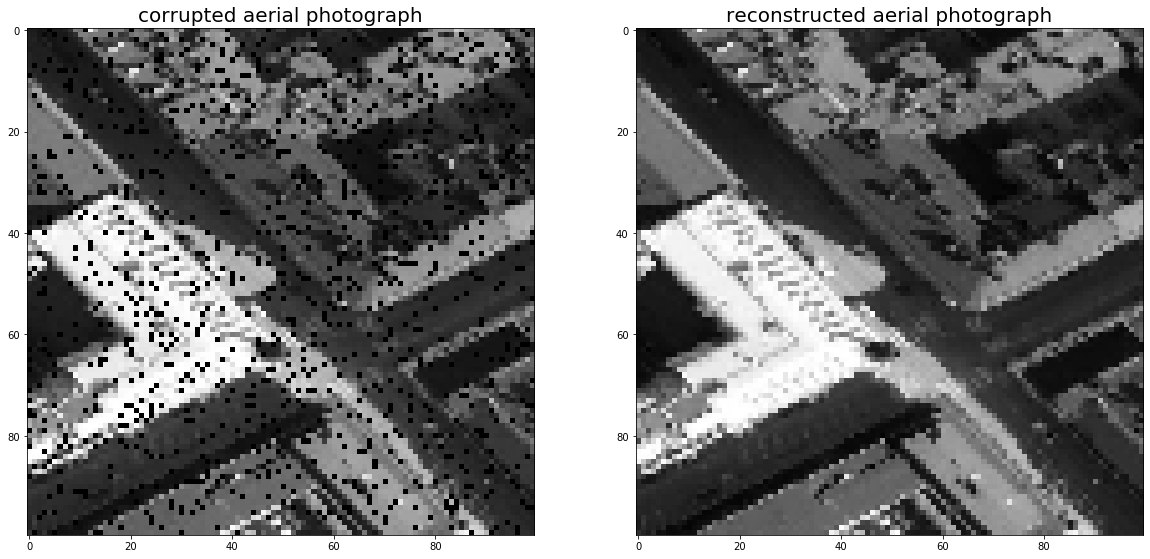

In [8]:
# plot the aearial photo with reconstructed corrupted pixels
DisplayRecoveredPixels(optimal_weight)

## Loss function

To measure the quality of a particular predictor $h^{(\mathbf{w})}(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$, obtained for some particular choice for the weight vector $\mathbf{w} \in \mathbb{R}^{n}$, we apply it to labeled data points, i.e., data points for which we know the correct label value $y$. For a labeled data point with features $\mathbf{x}^{(i)}$, we can compare its label $y^{(i)}$ with the predicted label $h^{(\mathbf{w})}(\mathbf{x}^{(i)}) = \mathbf{w}^{T} \mathbf{x}^{(i)}$. 

The prediction $h^{(\mathbf{w})}(\mathbf{x}^{(i)})$ will typically incur a non-zero __prediction error__ $y^{(i)} - h^{(\mathbf{w})}(\mathbf{x}^{(i)})$. To measure the error or **loss** incurred by the prediction $\hat{y}=h(\mathbf{x})$ (which is the result of applying the predictor function $h(\cdot)$ to the features $\mathbf{x}$), we need to define a loss function $\mathcal{L}(y,\hat{y})$. In principle, the loss function can be chosen freely by the ML scientist or engineer based on the application at hand. 

For numeric labels $y$, e.g. the label is a real number, a popular choice for the loss is the [squared error loss](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error) $\mathcal{L}(y,\hat{y}) = (y-\hat{y})^{2}$. Note that we can only evaluate the loss if we know the true label $y$ of a data point. Given a set of labeled data points $\big(\mathbf{x}^{(i)},y^{(i)}\big)$, we can compute the average loss 
\begin{equation*}
 \mathcal{E} (\mathbf{w}) = (1/m) \sum^{m}_{i=1}(y^{(i)} - \mathbf{w}^{T} \mathbf{x}^{(i)})^2
\label{eq2}
\tag{2}
\end{equation*}
for a particular predictor $h^{(\mathbf{w})}(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$.



The optimal weight vector $\mathbf{w}_{\rm opt}$ is any weight vector which achives the minimum value of $ \mathcal{E} (\mathbf{w})$, i.e., $$\mathcal{E} (\mathbf{w}_{\rm opt})= \min_{\mathbf{w} \in \mathbb{R}^{n}}\mathcal{E} (\mathbf{w})$$
An optimal predictor is then obtained as $h(\mathbf{x}) = \mathbf{w}_{\rm opt}^{T} \mathbf{x}$. The average loss 

$$\mathcal{E} (\mathbf{w}_{\rm opt}) = (1/m) \sum^{m}_{i=1}(y^{(i)} - \mathbf{w}_{\rm opt}^{T} \mathbf{x}^{(i)})^2$$
 
incurred by the optimal predictor $h(\mathbf{x}) = \mathbf{w}_{\rm opt}^{T} \mathbf{x}$ is also known as the **training error**. The training error is the average loss of the linear predictor which is optimal the labeled data points (the **training data**) $\big(\mathbf{x}^{(i)},y^{(i)}\big)$ for $i=1,\ldots,m$. 

The animation below illustrates the process of learning the optimal linear predictor (weights) by changing the weight vector $\mathbf{w}$ towards the minimum of the mean squared error function (2). The movement towards the minimum of the function is obtained by the [gradient descent algorithm](https://en.wikipedia.org/wiki/Gradient_descent). 

![SegmentLocal](../../../coursedata/R2_Regression/GD.gif "segment")

<a id='drawplot'></a>
<div class=" alert alert-info">
    
### Demo. Squared Error Loss
<p>
The code snippet below shows how to evaluate the quality of the linear predictor $h(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$ by using the squared error loss.  
</p>

The optimal weight vector $\mathbf{w}_{\rm opt}$ can be found by the function `LinearRegression.fit()`. The resulting optimal weight vector is stored in the variable `LinearRegression.coef_`. Using the optimal weight vector, we compute the training error 
\begin{equation}
(1/m) \sum_{i=1}^{m} \big( y^{(i)} - \mathbf{w}_{\rm opt}^{T} \mathbf{x}^{(i)} \big)^{2} 
\end{equation}
and store it in the variable `training_error`. 

</div>

In [9]:
# the class "LinearRegression" from the library scikit-learn allows to find 
# linear predictors that minimize the average squared error loss
from sklearn.linear_model import LinearRegression
# the function "mean_squared_error" allows to compute the average squared error 
# between two lists of label values (one list with true label values 
# and the other list with predicted label values)
from sklearn.metrics import mean_squared_error

# read in features and labels (grayscale values) of uncorrupted pixels 
X,y = GetFeaturesLabels(1000, 3)   
# create a LinearRegression object with no intercept term
# this object represents the space of predictor functions h(x) = w^{T}x
reg = LinearRegression(fit_intercept=False) 

# the method fit() determines the weight vector w such that the 
# average squared error between predicted label w^{T}x and true 
# label y is minimized for the labeled data points 
reg = reg.fit(X, y)

# after the optimal weight w has been determined determine the 
# corresponding average squared error (mean squared errror) on 
# the training set (which has been used to optimize the weight!)
training_error = mean_squared_error(y, reg.predict(X))

# display training error 
print("\nThe resulting average squared error (training error) is ", training_error)


The resulting average squared error (training error) is  742.2685991473817


<a id='varying_features'></a>
<div class=" alert alert-warning">
    <p><b>Student Task</b> Varying Number of Features. </p>
    
In principle, we can freely choose how many of the available features $x_{1}, x_{2},\ldots,x_{n}$ 
of a data point to use for predicting the label $y$. You are now to explore the effect of using a varying number $r \leq n$ of features on the resulting training error of linear regression. For each $r=1,2,\ldots,10$, fit a linear model (using `LinearRegression(fit_intercept=False)`) to the labeled dataset (using $m=10$ data points) by using only the first $r$ features $x_{1},...,x_{r}$ of a data point. 
<br />    
- You can get the first $r$ features and label of $m$ labeled data points using `GetFeaturesLabels(m,r)`.<br />
- For each value of $r$, determine the resulting training error (using the Python function `mean_squared_error()`) of the fitted linear model. <br />
- The results should be stored in a numpy array `linreg_error`, such that for the error for $r=1$ is stored in the first element, the error for $r=2$ in the second element etc..<br />

<p><b>HINT: In order to avoid mistakes, start looping from 0 (and not from 1)!</b></p>
<p><b>HINT: Don't use `GetFeaturesLabels` again inside the loop.</b></p>
</div>

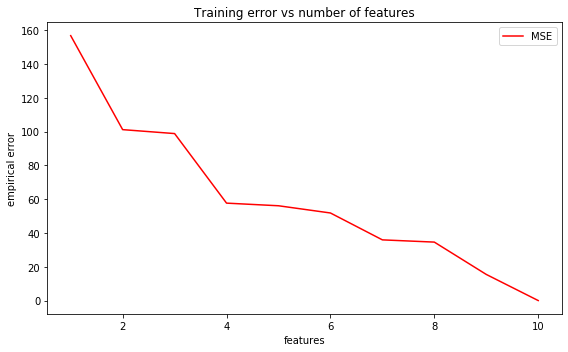

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# we use m data points (each data point representing an uncorrupted pixel) 
m = 10   
# maximum number of features used 
max_r = 10                        

# read in m data points using max_r features 
X, y = GetFeaturesLabels(m, max_r) 
  
# vector for storing the training error of LinearRegresion.fit() for each r
linreg_error = np.zeros(max_r)    

### STUDENT TASK ###
# reg = ...
# reg.xxx(...)
# y_pred = ...
# linreg_error[...] = ... 
# Hint: loop "max_r" times.

# YOUR CODE HERE
for i in range(0,max_r):
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X[:,:i+1], y)
    y_pred = reg.predict(X[:,:i+1])
    linreg_error[i] = mean_squared_error(y, y_pred)
#raise NotImplementedError()

# create a numpy array "r_values" containing the values 1,2...,max_r 
r_values = np.linspace(1, max_r, max_r, endpoint=True)
# create a plot object which can be accessed using variables "fig" and "axes"
fig, axes = plt.subplots(1,1, figsize=(8, 5))
# add a curve representing the average squared error for each choice of r 
axes.plot(r_values, linreg_error, label='MSE', color='red')
# add captions for the horizontal and vertical axes 
axes.set_xlabel('features')
axes.set_ylabel('empirical error')
# add a title to the plot 
axes.set_title('Training error vs number of features')
axes.legend()
plt.tight_layout()
# display the plot 
plt.show()

If the task completed correctly, you will see that the training error is decreasing if we use more features to build a linear predictor.
Note that features $x_{3},...x_{10}$ are synthetic random numbers that are in practice completely unrelated with the label $y$ (grayscale value of the center pixel). 

It might seem unintuitive that including these features reduces the error on the training data since we know that these have no real relationship with the label. However, a decreased training error does not necessarily correspond to a better predictive capability on new data. We will explore this issue in more detail in round 4 - for now it is sufficient to be aware of this fact and have faith in that the graph above does not defy common sense.

In [11]:
# this cell constains visible tests (sanity checks) and 
# hidden tests which are used for grading student solutions 

assert linreg_error.shape == (max_r,), "'linreg_error' has wrong dimensions."
assert linreg_error[9] < 0.01 * linreg_error[3], "training errors not correct"
assert linreg_error[5] > linreg_error[6], "training errors not correct"
print('sanity check tests passed!')


sanity check tests passed!


<a id='varying_features'></a>
<div class=" alert alert-warning">
<p><b>Student Task.</b> Varying Number of Data Points.</p>
    
Beside the number of features used to describe data points, another important parameter of a data set is the number $m$ of data points available. We need a sufficent amount of labeled data points to learn a useful predictor. 
    
Let us now explore the effect of using a varying number $m$ of data points on the average squared loss achieved by the optimal predictor. The optimal predictor is obtained by minimizing the average squared loss incurred on the $m$ labeled data points. 

- For each choice $m=1,2,\ldots,10$ read in the first $m$ data points of greyscales using $n=2$ features. This can be done using `GetFeaturesLabels(m,2)`.
- For each $m$, fit a linear model (using `LinearRegression(fit_intercept=False)`) to the first $m$ data points.
- Store the resulting training errors in the numpy array `train_error` of shape (10,). The $m$th entry of this array should be the training error obtained when using $m$ data points. Note that the first entry of a numpy array has index $0$, i.e., the value `train_error[0]` stores the training error obtained for `m=1`. 

<p><b>HINT: In order to avoid mistakes, start looping from 0 (and not from 1)!</b></p>
<p><b>HINT: Don't use `GetFeaturesLabels` again inside the loop.</b></p>
</div>

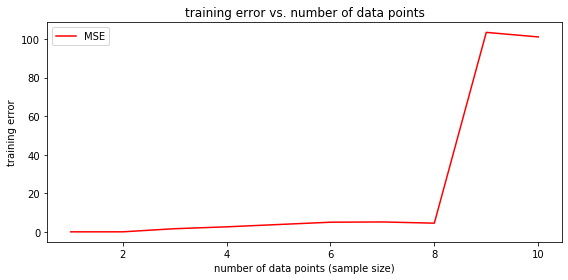

In [14]:
# maximum number of data points 
max_m = 10     

# read in max_m data points using n=2 features 
X, y = GetFeaturesLabels(max_m, 2)   

# create numpy array "train_error" for storing the average squared 
# error for each choice of number of data points, i.e., 
# train_error[0] is the average error for m=1 labeled data points, 
# train_error[1] is the average error for m=2 labeled data points, 
# ... 
# train_error[max_m-1] is the average error for m=m_max labeled data points
train_error = np.zeros(max_m)         

### STUDENT TASK ###
# train_error = ... 
# Hint: loop "max_m" times.
# YOUR CODE HERE
for i in range(0,max_m):
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X[:i+1], y[:i+1])
    y_pred = reg.predict(X[:i+1])
    train_error[i] = mean_squared_error(y[:i+1], y_pred)
#raise NotImplementedError()

# create a numpy array "m_values" containing the values 1,2...,max_m
m_values = np.linspace(1, max_m, max_m, endpoint=True)
# create a plot object which can be accessed using variables "fig" and "axes"
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
# add a curve representing the average squared error for each choice of r
axes.plot(m_values, train_error, label='MSE', color='red')
# add captions for axes of the plot 
axes.set_xlabel('number of data points (sample size)')
axes.set_ylabel('training error')
# add title for the plot 
axes.set_title('training error vs. number of data points')
axes.legend()
plt.tight_layout()
# display the plot 
plt.show()

If the task completed correctly, you will see that the training error is increasing if we use more datapoints to fit a linear predictor. Why do you think increasing sample size lead to increase in the training error?

In [15]:
# this cell constains visible tests (sanity checks) and 
# hidden tests which are used for grading student solutions 

assert train_error.shape == (10,), "'train_error' has wrong dimensions."
assert train_error[0] < 100 * train_error[3], "training errors not correct"
assert train_error[2] > train_error[1], "training errors not correct"

print('sanity check tests passed!')


sanity check tests passed!


## Robustness 

An important property of ML methods is their robustness to (small) perturbations in the data. In some applications, few data points might be corrupted (such as the pixels of an aerial photograph) and therefore intrinsically different from all other data points. We prefer ML methods which are affected only little by an error in a few data points.

<a id='drawplot'></a>
<div class=" alert alert-info">
    
### Demo. Robustness of Linear Regression with Squared Error Loss.
<p>
The code snippet below considers fitting a linear model for greyscales $y$ based on a single feature $x_{1}$. The resulting linear predictor minimizes the average squared error loss on the training data. We then intentionally perturb the first data point by setting $y_{1}^{(1)}$ to an unreasonable value. Using this corrupted data set, we then fit a linear model again and compare the so-obtained linear predictor to the linear predictor obtained previously from the "clean" data set.
</p>
</div>

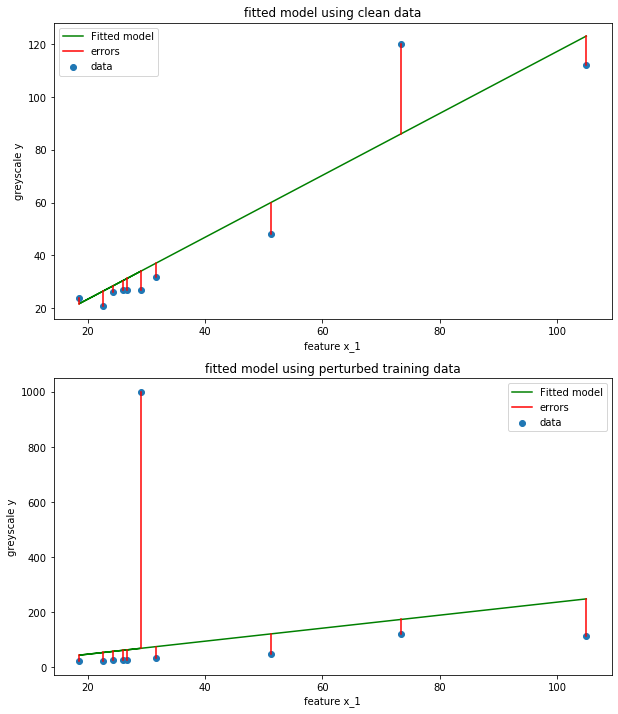

optimal weight w_opt by fitting to (training on) clean training data :  1.172291483907032
optimal weight w_opt by fitting to (training on) perturbed training data :  2.3623678265548533


In [16]:
from sklearn import linear_model

# read in 10 data points with single feature x_1 and label y 
X,y = GetFeaturesLabels(10,1)   

### fit a linear model to the clean data 
reg = linear_model.LinearRegression(fit_intercept=False)
reg = reg.fit(X, y)
y_pred = reg.predict(X)

# now we intentionally perturb the label of the first data point 
y_perturbed = np.copy(y)  
y_perturbed[0] = 1000; 

### fit a linear model to the perturbed data 
reg1 = linear_model.LinearRegression(fit_intercept=False)
reg1 = reg1.fit(X, y_perturbed)
y_pred_perturbed = reg1.predict(X)

# create a plot object which can be accessed using variables "fig" and "axes"
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
# plot datapoints
axes[0].scatter(X, y, label='data')
# plot linear predictor
axes[0].plot(X, y_pred, color='green', label='Fitted model')

# now add individual line for each error point
axes[0].plot((X[0], X[0]), (y[0], y_pred[0]), color='red', label='errors') # add label to legend
for i in range(len(X)-1):
    lineXdata = (X[i+1], X[i+1]) # same X
    lineYdata = (y[i+1], y_pred[i+1]) # different Y
    axes[0].plot(lineXdata, lineYdata, color='red')

# set axes title, labels and legend
axes[0].set_title('fitted model using clean data')
axes[0].set_xlabel('feature x_1')
axes[0].set_ylabel('greyscale y')
axes[0].legend()

# plot datapoints
axes[1].scatter(X, y_perturbed, label='data')
# plot linear predictor 
axes[1].plot(X, y_pred_perturbed, color='green', label='Fitted model')

# now add individual line for each error point
axes[1].plot((X[0], X[0]), (y_perturbed[0], y_pred_perturbed[0]), color='red', label='errors') # add label to legend
for i in range(len(X)-1):
    lineXdata = (X[i+1], X[i+1]) # same X
    lineYdata = (y_perturbed[i+1], y_pred_perturbed[i+1]) # different Y
    axes[1].plot(lineXdata, lineYdata, color='red')

# set axes title, labels and legend
axes[1].set_title('fitted model using perturbed training data')
axes[1].set_xlabel('feature x_1')
axes[1].set_ylabel('greyscale y')
axes[1].legend()

plt.show()

print("optimal weight w_opt by fitting to (training on) clean training data : ", reg.coef_[0,0])
print("optimal weight w_opt by fitting to (training on) perturbed training data : ", reg1.coef_[0,0])

By observing the plots above, we can see that the perturbed data point has a very large effect on the optimal predictor. Assuming that the perturbed data point is a true outlier in the sense that it is not from the same distribution as the other points, the inclusion of this data point will result in a predictor that has poor predictive performance on data from the real distribution.

One solution to this problem is to attempt to remove outliers from the data. Another approach that we will explore next is to use a loss function that is **robust to outliers**, i.e. the trained predictor is less affected by the outliers.

## Using Different Loss Function 

The choice of loss function used for a ML methods is a pure design choice. So far, we have focused on the squared error loss since it has convenient computational properties (it can be minimized efficiently, e.g., using gradient descent). However, we will now discuss why it might be a good idea to use a different loss function. 

We observe from the demo above that the resulting linear predictor is heavily affected by corrupting only one single data point. The reason for this sensitivity is rooted in the properties of the squared error loss function used by the class `LinearRegression()`. Indeed by using the loss $(\hat{y} - y)^{2}$ we force the predictor $\hat{y}$ to not be too far away from any data point with very large value $y$ of the true label. 
 
It turns out that using a different loss function to learn a linear predictor can make the learning robust against few outliers. One such robust loss function is known as ["Huber loss"](https://en.wikipedia.org/wiki/Huber_loss) $\mathcal{L}(\hat{y},y)$. Given a data point with label $y$ and a predicted label $\hat{y}=h(\mathbf{x})$ the Huber loss is defined as 
$$\mathcal{L}(y,\hat{y}) = \begin{cases} (1/2) (y-\hat{y})^{2} & \mbox{ for } |y-\hat{y}| \leq   \varepsilon \\ 
\varepsilon(|y-\hat{y}| - \varepsilon/2) & \mbox{ else. }\end{cases}$$

Note that the Huber loss contains a parameter $c$ which has to be adapted to the application at hand. 

To learn a linear predictor $h(\mathbf{x}) = \mathbf{w}^{T} \mathbf{x}$ which minimizes the average Huber loss over the labeled data points in the training set we can use the [`HuberRegressor()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html) class. 

The Huber loss contains two important special cases. The first special case is obtained when $\varepsilon$ is chosen very large (the precise value depending on the value range of the features and labels) such that the condition $|y-\hat{y}| \leq \varepsilon$ is always satisfied. In this case, the Huber loss becomes the squared error loss $(y-\hat{y})^{2}$ (with an additional factor 1/2). The second special case is obtained for choosing $\varepsilon$ very small (close to $0$) such that the condition $|y-\hat{y}| \leq \varepsilon$ is never satisfied. In this case, the Huber loss becomes the absolute loss $|y - \hat{y}|$ scaled by a factor $\varepsilon$.

<img src="../../../coursedata/R2_Regression/Huber4.jpg" alt="Drawing" style="width: 1000px"/>

<a id='drawplot'></a>
<div class=" alert alert-info">

### Demo. Squared Error and Huber Loss
<p>
The code below plots the squared error loss and the Huber loss for different choices of the parameter $\varepsilon$. Note that the Huber loss reduces to the squared error loss for a sufficiently large value of the parameter $\varepsilon$.
</p>
</div>

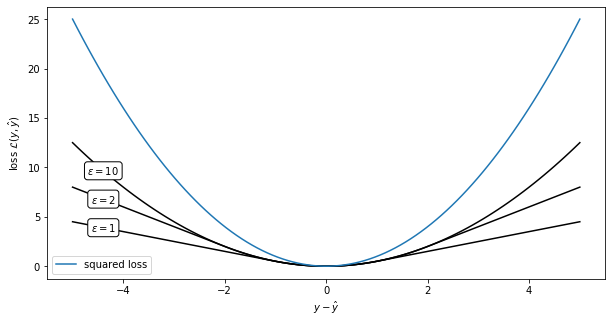

In [17]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
import matplotlib.pyplot as plt


#------------------------------------------------------------
# Define the Huber loss
def HuberLoss(pred_error, epsilon):
    # pred_error - prediction error y-y_pred
    # epsilon - parameter epsilon 𝜀 
    pred_error = abs(pred_error)
    flag = (pred_error > epsilon)
    return (~flag) * (0.5 * pred_error ** 2) - (flag) * epsilon * (0.5 * epsilon - pred_error)

#------------------------------------------------------------
# Plot for several values of epsilon
fig = plt.figure(figsize=(10, 5)) # set figure size
ax = fig.add_subplot(111) # add 1 subplot

pred_error = np.linspace(-5, 5, 100) # create linear space from -5 to 5 with 100 steps

for epsilon in (1, 2, 10): # loop through values 1, 2, 10
    loss = HuberLoss(pred_error, epsilon)
    ax.plot(pred_error, loss, '-k') # plot x and y

    if epsilon > 10:
        s = r'\infty' # set s to infinity sign (string format)
    else:
        s = str(epsilon) # set s to string of number epsilon

    ax.text(pred_error[6], loss[6], '$\epsilon=%s$' % s,
            ha='center', va='center',
            bbox=dict(boxstyle='round', ec='k', fc='w')) # add test to each line

ax.plot(pred_error, np.square(pred_error),label="squared loss") # plot the sqared loss (blue line)

ax.set_xlabel(r'$y - \hat{y}$') # set x labels
ax.set_ylabel(r'loss $\mathcal{L}(y,\hat{y})$') # set y label
ax.legend() # show legend in plot
plt.show() # show the plot

Assume we have a dataset that could be perfectly fitted to a linear function with the exception of one outlier data point. Let's take a look at two linear predictors. The first linear predicturs uses some weight vector $\mathbf{w}^{(1)}$ and the other predictor using a different weight vector $\mathbf{w}^{(2)}$. 

The weight vector $\mathbf{w}^{(1)}$ is chosen such that $h(\mathbf{x}) = \big(\mathbf{w}^{(1)} \big)^{T} \mathbf{x}$ perfectly fits the data points which are not outliers (see top-left plot below). 

The weight vector $\mathbf{w}^{(2)}$ is chosen by minimizing the avaerage squared error loss over ALL data points (including the outlier). 

We see that one data point is outlier and model 1 is an optimal predictor for the dataset. Let's see how differents loss functions estimate the quality of these predictors. On the right side absolute, square and huber loss for each datapoint is plotted and total loss indicated in the subplots legends. What can you say about robustness of these loss functions to the outlier?

<img src="../../../coursedata/R2_Regression/Huber.png" alt="Drawing" style="width:1000px"/>

<a id='drawplot'></a>
<div class=" alert alert-info">
    
### Demo. Robustness of Linear Regression with Huber Loss.

<p>The code snippet below fits a linear model for greyscales $y$ based on a single feature $x_{1}$ using the Huber loss. We also intentionally perturb the first data point by setting $y_{1}^{(1)}$ to an unreasonable value. Using this corrupted data set, we fit a linear model (under Huber loss) again and compare the so-obtained linear predictor to the linear predictor obtained from the "clean" data set.</p>
</div>

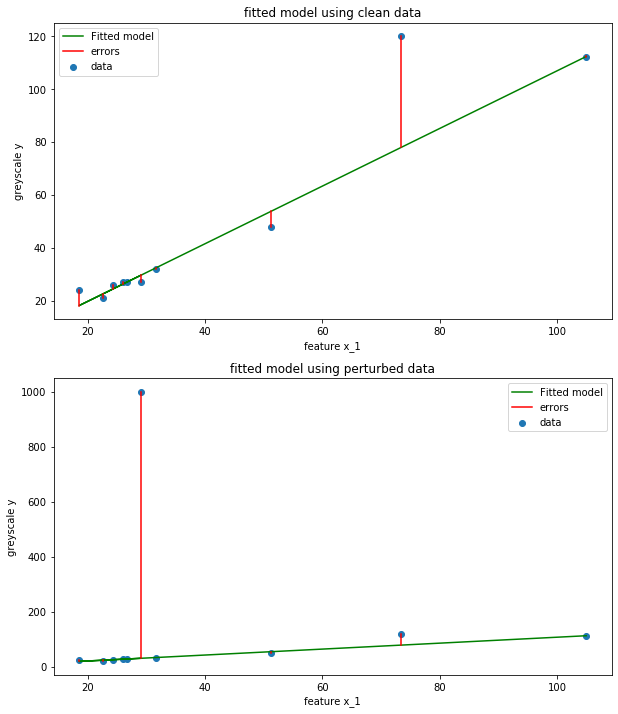

optimal weight w_opt by fitting on clean data :  1.0890434272688132
optimal weight w_opt by fitting on perturbed data :  1.0804854338400913


In [18]:
from sklearn import linear_model
from sklearn.linear_model import HuberRegressor

X,y = GetFeaturesLabels(10,1)   # read in 10 data points with single feature x_1 and label y 

# regressor gives a warning if this isn't done, changes y.shape from (10, 1) to (10,)
y = y.ravel()

### fit a linear model (using Huber loss) to the clean data 
reg = HuberRegressor().fit(X, y)
y_pred = reg.predict(X)

# now we intentionaly perturb the label of the first data point 
y_perturbed = np.copy(y)  
y_perturbed[0] = 1000; 

### fit a linear model (using Huber loss) to the perturbed data 
reg1 = HuberRegressor().fit(X, y_perturbed)
y_pred_perturbed = reg1.predict(X)

# create a plot object which can be accessed using variables "fig" and "axes"
fig, axes = plt.subplots(2, 1, figsize=(10,12))
# plot datapoints
axes[0].scatter(X, y, label='data')
# plot linear predictor
axes[0].plot(X, y_pred, color='green', label='Fitted model')

# now add individual line for each error point
axes[0].plot((X[0], X[0]), (y[0], y_pred[0]), color='red', label='errors') # add label to legend
for i in range(len(X)-1):
    lineXdata = (X[i+1], X[i+1]) # same X
    lineYdata = (y[i+1], y_pred[i+1]) # different Y
    axes[0].plot(lineXdata, lineYdata, color='red')

# set axes title, labels and legend
axes[0].set_title('fitted model using clean data')
axes[0].set_xlabel('feature x_1')
axes[0].set_ylabel('greyscale y')
axes[0].legend()

axes[1].scatter(X, y_perturbed, label='data')
# plot linear predictor
axes[1].plot(X, y_pred_perturbed, color='green', label='Fitted model')

# now add individual line for each error point
axes[1].plot((X[0], X[0]), (y_perturbed[0], y_pred_perturbed[0]), color='red', label='errors') # add label to legend
for i in range(len(X)-1):
    lineXdata = (X[i+1], X[i+1]) # same X
    lineYdata = (y_perturbed[i+1], y_pred_perturbed[i+1]) # different Y
    axes[1].plot(lineXdata, lineYdata, color='red')

# set axes title, labels and legend
axes[1].set_title('fitted model using perturbed data')
axes[1].set_xlabel('feature x_1')
axes[1].set_ylabel('greyscale y')
axes[1].legend()

plt.show()

print("optimal weight w_opt by fitting on clean data : ", reg.coef_[0])
print("optimal weight w_opt by fitting on perturbed data : ", reg1.coef_[0])

We can see that the predictors trained on the original and perturbed data are very similar when using the Huber loss, in contrast to the large difference in the predictors that minimize the mean-squared error.

<a id='varying_features'></a>
<div class=" alert alert-info">
    
### Demo. Varying Number of Features with Huber Loss. 
    
In principle you can choose how many of the available features $x_{1}, x_{2},\ldots,$ 
of a pixel you want to use to in order to predict the greyscale $y$. Let us now explore 
the effect of using a varying number $r$ of features on the resulting error and 
computational complexity (runtime). <br />

In particular, for each $r=1,2,\ldots,10$, the code snippet below fits a linear model under 
Huber loss to the pixels dataset (using $m=10$ data points) by using only the 
first $r$ features $x_{1},...,x_{r}$ of a pixel. 
<br />    
- The first $r$ features and labels (greyscale) for the pixels can be obtained using `GetFeaturesLabels(m,r)`.<br />
- For each value of $r$, the resulting training error (using the Python function `mean_squared_error()`) of the fitted linear model is calculated. <br />
- The results are stored in the vector `linreg_error`. 

</div>

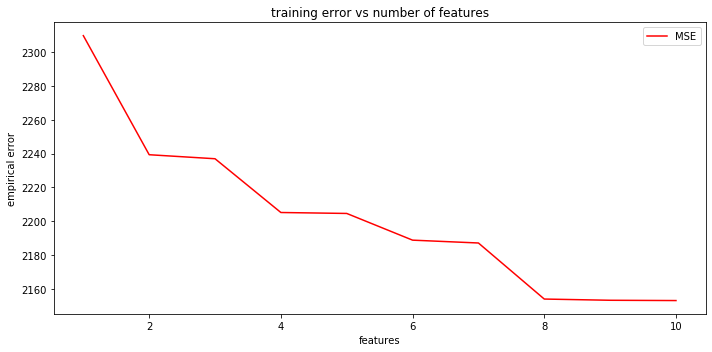

In [19]:
from sklearn import preprocessing

# we use 10 data points (each data point representing an uncorrupted pixel)
m = 10   

# maximum number of features used to characterize a data point
max_r = 10                        

# read in m data points each described by max_r features
X,y = GetFeaturesLabels(m, max_r)  

# scale the features
X = preprocessing.scale(X)

# vector for storing the training error of LinearRegresion.fit() for each r
linreg_error = np.zeros(max_r)    

for r in range(max_r):
    # create an object "reg_hub" which represents a linear hypothesis space 
    # consisting of predictor maps h(x) = w^{T} x  (without an intercept term or "offset")
    # this object uses the Huber loss function for finding the best weight vector 
    reg_hub = HuberRegressor(fit_intercept=False) 
    # find the best weight vector w by minimizing the average Huber loss 
    # the resulting optimal weight vector is stored in "reg_hub.coef_" 
    reg_hub = reg_hub.fit(X[:,:(r+1)], y.ravel())
    # apply the optimal linear predictor (using optimal weight vector) to the 
    # data points whose feature vectors are stored in numpy array "X"
    pred = reg_hub.predict(X[:,:(r+1)])
    # computer the resulting average squared loss incurred by the optimal predictor 
    linreg_error[r] = mean_squared_error(y, pred)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# create a numpy array "r_vals" containing the values 1,2...,max_r
r_vals = np.linspace(1, max_r, max_r, endpoint=True)

# add curve depicting the resulting training error for each choice of number r of features 
ax.plot(r_vals, linreg_error, label='MSE', color='red')

# add captions to plot 
ax.set_xlabel('features')
ax.set_ylabel('empirical error')
ax.set_title('training error vs number of features')
ax.legend()
plt.tight_layout()
plt.show()

<a id='varying_features'></a>
<div class=" alert alert-warning">
<p><b>Student Task</b> Choosing the optimal epsilon for HuberRegressor</p>
    


The Huber loss depends on a tuning-parameter $\varepsilon$ which should be adapted to the application at hand. For example, if we want to use the value $\varepsilon=1.1$ we need to use the Python command 

`reg = HuberRegressor(epsilon = 1.1).fit(X,y)` 

to determine the optimal predictor which minimizes the Huber loss with $\varepsilon=1.1$. 

One simple approach to implement this is to try out different values for $\varepsilon$. For each value of $\varepsilon$, we compute a linear predictor by minimizing the average Huber loss for that choice of $\varepsilon$. We then compare the resulting training errors achieved by these (typically different) predictors that are obtained for different choices of $\varepsilon$. 

- read in $m=10$ data points, each data point characterized by $n=1$ feature and a numeric label 
- store the features of the data points in the numpy array `X`of shape (10,1) 
- store the labels of the data points in the numpy array `y`of shape (10,1)  
- create anoter numpy array `y_perturbed` which is identifcal with `y` except for the first entry which is set to `y_perturbed[0]=10000`
- determine the weight vectors $\mathbf{w}^{(\varepsilon)}$ for a linear predictor by minimizing the average Huber loss for the choices $\varepsilon=1,1.2,1.4,1.6,1.8,2$ on the perturbed data points (using features `X` and labels `y_perturbed`)
- for each of the resulting linear predictors $h(\mathbf{x}) = \big( \mathbf{w}^{(\varepsilon)} \big)^{T} \mathbf{x}$, determine the average squared error loss incurred on the $m-1$ labeled data points (use the function `mean_squared_error()` for this) whose features are stored in `X[1:]` and labels in `y[1:]`. Thus, we evaluate the predictor on the $m-1$ unperturbed data points. 
- store the resulting average squared error loss in the numpy array `err_vs_epsilon` of shape (6,1)

</div>

In [20]:
from sklearn import linear_model
from sklearn.linear_model import HuberRegressor

# read in 10 data points with single feature x_1 and label y 
X,y = GetFeaturesLabels(10,1)  

# create a numpy array with the values for the paramter c 
epsilon_vals = [1,1.2,1.4,1.6,1.8,2]

# create a numpy array "y_perturbed" by copying the values of the 
# numpy array "y" which contains the label values of the data points 
y_perturbed = np.copy(y)  

# now we intentionaly perturb the label of the first data point 
# by setting it to 10000
y_perturbed[0] = 10000; 

### STUDENT TASK ###
# YOUR CODE HERE
err_vs_epsilon = np.zeros(6)
y_perturbed = y_perturbed.ravel()
i = 0
for eps in epsilon_vals:
    reg = HuberRegressor(epsilon = eps).fit(X,y_perturbed)
    err_vs_epsilon[i] = mean_squared_error(y[1:], reg.predict(X[1:]))
    i += 1
#raise NotImplementedError()

# Print errors
print('Errors:')
print(err_vs_epsilon)

Errors:
[203.88551581 203.01356722 198.22362636 192.9971804  182.20468335
 179.82521513]


In [21]:
# this cell contains visible tests (sanity checks) and 
# hidden tests which are used for grading student solutions 

assert err_vs_epsilon.shape[0] == 6, "'linreg_error' has wrong dimensions."
assert err_vs_epsilon[2] < err_vs_epsilon[1], "training errors not correct"
assert err_vs_epsilon[1] < err_vs_epsilon[0], "training errors not correct"

print('Sanity check tests passed!')


Sanity check tests passed!


<a id='Bonus Huber'></a>
<div class=" alert alert-warning">
    <b>Bonus Task.</b> Huber loss. 
    
Bonus task worth of 50 points.
    
Explain the meaning of parameter "epsilon" in HuberRegressor. In particular, how would you choose the value "epsilon" for the Huber loss based on some prior knowledge about the (properties of the) outliers? 
</div>

## Take Home Quiz

Try to answer the following questions by setting the `answer_R2_Q??` 
variable for each question to the number of the correct answer. E.g. if you think that the second answer in the first quiz question is the right one, then set `answer_R2_Q1=2`. 

<a id='QuestionR2_1'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R2.1. </p>

 <p>When is a machine learning problem called a regression problem ?</p>

<ol>
  <li> When the quantity of interest (the label) is a numeric quantity. </li>
  <li> When the data is stored in a spreadsheet.</li>
  <li> When the method uses audio data.  </li>
  <li> When the quantity of interest takes on only a finite number of different values (e.g. "-1","0" or "4").
</ol> 

</div>

In [22]:
# answer_Q1

# answer_R2_Q1  = ...
# YOUR CODE HERE
answer_R2_Q1 = 1
#raise NotImplementedError()

In [23]:
# this cell constains visible tests (sanity checks) and 
# hidden tests which are used for grading student solutions 

assert answer_R2_Q1 in [1, 2, 3, 4], '"answer_R2_Q1" Value should be an integer between 1 and 4.'
print('Sanity check tests passed!')


Sanity check tests passed!


<a id='QuestionR2_2'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R2.2.</p>
    <p> What is the effect of using more features for learning (fitting) a linear predictor via minimizing the average squared error on training data?</p>
    <ol>
      <li> The training error typically increases. </li>
      <li> The training error typcially decreases. </li>
      <li> The training error does not depend on the number of features. </li>
    </ol> 
</div>

In [24]:
# answer_Q2

# answer_R2_Q2  = ...
# YOUR CODE HERE
answer_R2_Q2 = 2
#raise NotImplementedError()

In [25]:
# test cell, please don't remove.

assert answer_R2_Q2 in [1, 2, 3], '"answer_R2_Q2" Value should be an integer between 1 and 3.'
print('Sanity check tests passed!')


Sanity check tests passed!


<a id='QuestionR2_3'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R2.3.</p>
    <p> What is the effect of adding more data points to the training data when using linear predictors and the squared error loss?</p>
    <ol>
      <li> The training error always decreases when adding more data points to the training set.  </li>
      <li> The training error might increase when adding more data points to the training set.  </li>
    </ol> 
</div>

In [26]:
# answer_Q3

# answer_R2_Q3  = ...
# YOUR CODE HERE
answer_R2_Q3 = 2
#raise NotImplementedError()

In [27]:
# this cell constains visible tests (sanity checks) and 
# hidden tests which are used for grading student solutions 

assert answer_R2_Q3 in [1, 2], '"answer_R2_Q3" Value should be an integer between 1 and 2.'
print('Sanity check tests passed!')


Sanity check tests passed!


<a id='QuestionR2_4'></a>
<div class=" alert alert-warning">
    <p><b>Student Task.</b> Question R2.4.</p>
    <p> How does the resulting regression method differ when using either squared error or Huber loss?</p>
    <ol>
      <li> Using Huber loss makes the resulting method more robust against outliers, i.e., the learned predictor does not vary too much if a few training data points are perturbed.  </li>
      <li> Using squared error loss makes the resulting method more robust against outliers.  </li>
    </ol> 
</div>

In [28]:
# answer_Q4

# answer_R2_Q4  = ...
# YOUR CODE HERE
answer_R2_Q4 = 1
#raise NotImplementedError()

In [29]:
# this cell constains visible tests (sanity checks) and 
# hidden tests which are used for grading student solutions 

assert answer_R2_Q4 in [1, 2, 3], '"answer_R2_Q4" Value should be an integer between 1 and 3.'
print('Sanity check tests passed!')


Sanity check tests passed!
